## Лабораторная работа №2

выполнил: Формалёв Александр, 308Б-22

### Ход работы

Импортируем библиотеки

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn import metrics

Загружаем датасет

In [96]:
df = pd.read_csv("./train.csv")

Заведём несколько вспомогательных переменных

In [97]:
target_feature = ['source_attractiveness']
categorial_features = ['category']
real_features = ['clicks', 'likes', 'buys', '4xx_errors', 'complaints_count', 'average_dwelltime', 'lifetime'] # ниже будет пояснение

Посмотрим информацию об исходном датафрейме

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             8000 non-null   int64  
 1   category               8000 non-null   object 
 2   clicks                 7727 non-null   float64
 3   likes                  7624 non-null   float64
 4   buys                   8000 non-null   int64  
 5   4xx_errors             8000 non-null   int64  
 6   5xx_errors             8000 non-null   int64  
 7   complaints_count       7527 non-null   object 
 8   average_dwelltime      8000 non-null   float64
 9   source_attractiveness  8000 non-null   float64
 10  date_of_registration   8000 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 687.6+ KB


Необходимо обработать признаки category, complaints_count и date_of_registration. Начнём с того, что приведём complaints_count к числовому типу данных

In [99]:
df['complaints_count'] = pd.to_numeric(df['complaints_count'], errors='coerce')

Заменим признак даты регистрацию на текущее время работы сайта

In [100]:
df['lifetime'] = (datetime.now() - pd.to_datetime(df['date_of_registration'], errors='coerce')) / pd.Timedelta(days=365)

Теперь необходимо проверить наличие неопределённых и пустых значений в датафрейме

In [101]:
df.isnull().sum()

Unnamed: 0                 0
category                   0
clicks                   273
likes                    376
buys                       0
4xx_errors                 0
5xx_errors                 0
complaints_count         884
average_dwelltime          0
source_attractiveness      0
date_of_registration       0
lifetime                   0
dtype: int64

В датафрейме есть такие значения. Заменим их на среднее значение по признаку (удаление записей, содержащих nan, или замена на моду будут иметь такое же влияние на обучение модели, поэтому без разницы, как именно мы будем избавляться от nan)

In [102]:
df[real_features] = df[real_features].fillna(df[real_features].mean())

К признаку category необходимо применить OneHotEncoding. Для удобства сохраним отдельно результат отдельно от датафрейма и разобъём датафрейм для последующего обучения модели

In [103]:
df_train, df_test = train_test_split(df, test_size=0.2)

one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)

X_train_category = one_hot_encoder.fit_transform(df_train[categorial_features])
X_test_category = one_hot_encoder.transform(df_test[categorial_features])

Теперь взглянем на корреляционную матрицу некатегориальных признаков датафрейма

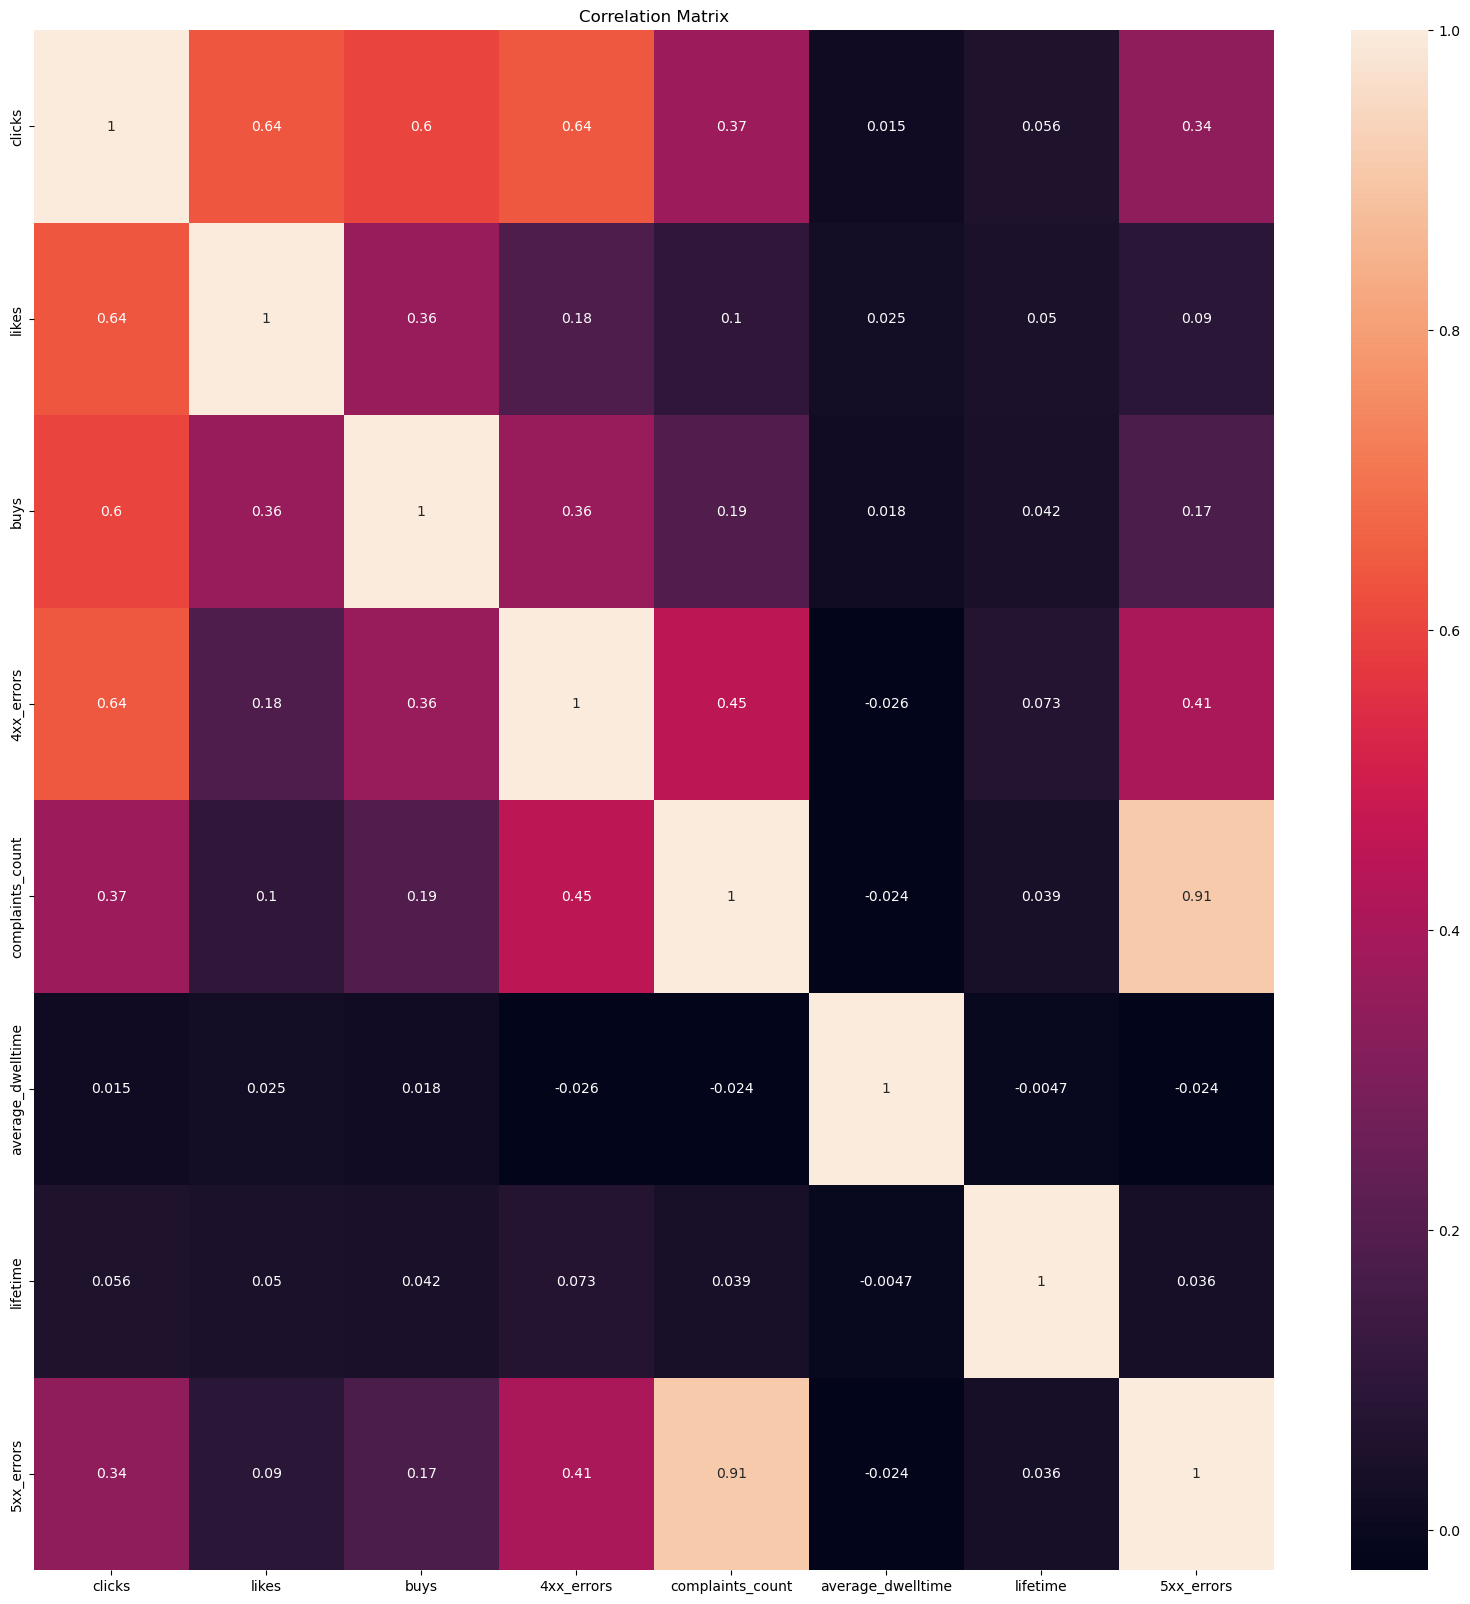

In [104]:
cor_matrix = df[real_features].join(df['5xx_errors']).corr()

plt.figure(figsize=(20, 20))
sns.heatmap(cor_matrix, annot=True)
plt.title('Сorrelation Matrix')
plt.show()

Как можно заметить, признаки 5xx_errors и complaints_count сильно коррелируют, поэтому один из них можно удалить (я решил удалить 5xx_errors, поэтому изначально и не включил его в массив real_features)

Осталось только обучить модель и оценить MSE

In [105]:
model = LinearRegression(fit_intercept=True)

X_train = np.hstack([df_train[real_features], X_train_category])
X_test = np.hstack([df_test[real_features], X_test_category])

model.fit(X_train, df_train[target_feature])
y_test = model.predict(X_test)

print(metrics.mean_squared_error(df_test[target_feature], y_test))

0.016413207433947696


В итоге была проведена достаточная предобработка данных и их анализ